### imports

In [1]:
import os
import numpy as np
import itertools

import matplotlib.pyplot as plt

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

### constants

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
IMG_SHAPE = IMG_SIZE + (3,)

### loading datasets

In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
)

dataset_path = os.path.join('dataset', 'prajna')
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
valid_path = os.path.join(dataset_path, 'valid')

train_batches = datagen.flow_from_directory(train_path, target_size=IMG_SIZE)
valid_batches = datagen.flow_from_directory(valid_path, target_size=IMG_SIZE)
test_batches = datagen.flow_from_directory(test_path, target_size=IMG_SIZE, shuffle=False)

Found 964 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 137 images belonging to 2 classes.


### creating model

In [4]:
basemodel = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE, # 224 x 224 x 3
    input_tensor=Input(shape=IMG_SHAPE)
)
basemodel.trainable = False

In [5]:
x = basemodel.output
x = GlobalAveragePooling2D()(x)
x = Dense(224, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

#### compiling model

In [6]:
model = Model(inputs=basemodel.input, outputs=predictions)

model.compile(
    optimizer=Adam(), 
    loss=BinaryCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

#### training model

In [7]:
history = model.fit(
    train_batches,
    steps_per_epoch=train_batches.samples // train_batches.batch_size,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples // valid_batches.batch_size,
    epochs=EPOCHS
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30 steps, validate for 8 steps
Epoch 1/20
30/30 [==============================] - 30s 997ms/step - loss: 0.6890 - accuracy: 0.6416 - val_loss: 0.6084 - val_accuracy: 0.8672
Epoch 2/20
30/30 [==============================] - 23s 770ms/step - loss: 0.6145 - accuracy: 0.8219 - val_loss: 0.5580 - val_accuracy: 0.9609
Epoch 3/20
30/30 [==============================] - 28s 949ms/step - loss: 0.5865 - accuracy: 0.8830 - val_loss: 0.5459 - val_accuracy: 0.9609
Epoch 4/20
30/30 [==============================] - 26s 880ms/step - loss: 0.5614 - accuracy: 0.9238 - val_loss: 0.5348 - val_accuracy: 0.9766
Epoch 5/20
30/30 [==============================] - 26s 860ms/step - loss: 0.5509 - accuracy: 0.9345 - val_loss: 0.5410 - val_accuracy: 0.9453
Epoch 6/20
30/30 [==============================] - 26s 852ms/step - loss: 0.5456 - accuracy: 0.9378 - val_loss: 0.5372 - val_accuracy: 0.9609
Epoch 7/20
30/30 [==============================] -

#### saving model

In [8]:
model_path = 'my_trained_model.model'
print(datetime.now(), '- salvando o modelo em ', model_path)
model.save(model_path, save_format="h5")

2021-08-22 08:51:09.767317 - salvando o modelo em  my_trained_model.model


#### plotting model accuracy and loss

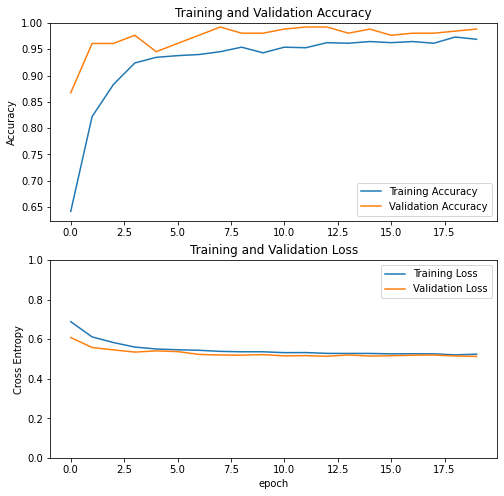

In [9]:
%matplotlib inline
plot_path = 'my_model_metrics.png'
#print(datetime.now(), '- criando plot das métricas e salvando em', plot_path)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(plot_path)
plt.show()

#print(datetime.now(), '- FIM DO SCRIPT')


#### model evaluation

In [10]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
test_labels = test_batches.classes
test_batches.class_indices

{'with_mask': 0, 'without_mask': 1}

In [23]:
#pred = model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size)
pred = model.predict(test_batches, steps=test_batches.samples)
results = dict(zip(model.metrics_names, pred))
print(results)

{'loss': array([9.9989784e-01, 1.0213045e-04], dtype=float32), 'accuracy': array([9.9999666e-01, 3.3606316e-06], dtype=float32)}


In [27]:
pred.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, pred.argmax(axis=1))
cm

array([[69,  0],
       [ 1, 67]], dtype=int64)

Confusion matrix, without normalization
[[69  0]
 [ 1 67]]


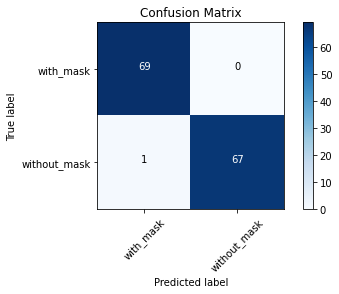

In [29]:
cm_plot_labels = ['with_mask', 'without_mask']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')